# Colab init

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import os
sys.path.append("/content/drive/MyDrive/MLEX3")
%cd /content/drive/MyDrive/MLEX3/

/content/drive/MyDrive/MLEX3


In [3]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.4 MB/s eta 0:00:00


# Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Softmax, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import DeepFool
from art.attacks.evasion import UniversalPerturbation

# Loading and splitting dataset

In [5]:
def load_dataset(directory, size=(64,64)):
    X, y = [], []
    for folder in os.listdir(directory):
        label = int(folder[1:])  # folders 's1', 's2'...
        folder_path = os.path.join(directory, folder)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            image = image.resize(size) # resize to 64x64
            X.append(np.array(image))
            y.append(label)
    X = np.array(X) / 255.0  # normalize
    y = np.array(y) - 1  # labels start 0, not 1
    return X, y

In [6]:
X, y = load_dataset('data/')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = X_train.reshape((-1, 64, 64, 1))
X_val = X_val.reshape((-1, 64, 64, 1))
X_test = X_test.reshape((-1, 64, 64, 1))

# Build and train model

In [7]:
def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(40, activation='softmax')  # 40 classes
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
model = build_model((64, 64, 1))

# instance early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
15/15 [==============================] - 6s 21ms/step - loss: 3.7003 - accuracy: 0.0292 - val_loss: 3.6940 - val_accuracy: 0.0500
Epoch 2/50
15/15 [==============================] - 0s 8ms/step - loss: 3.6492 - accuracy: 0.0667 - val_loss: 3.7252 - val_accuracy: 0.0375
Epoch 3/50
15/15 [==============================] - 0s 9ms/step - loss: 3.5391 - accuracy: 0.1083 - val_loss: 3.6269 - val_accuracy: 0.0375
Epoch 4/50
15/15 [==============================] - 0s 10ms/step - loss: 3.2357 - accuracy: 0.2167 - val_loss: 3.3044 - val_accuracy: 0.2000
Epoch 5/50
15/15 [==============================] - 0s 10ms/step - loss: 2.7310 - accuracy: 0.3250 - val_loss: 2.7964 - val_accuracy: 0.2250
Epoch 6/50
15/15 [==============================] - 0s 9ms/step - loss: 2.0963 - accuracy: 0.4458 - val_loss: 2.2287 - val_accuracy: 0.4375
Epoch 7/50
15/15 [==============================] - 0s 9ms/step - loss: 1.5170 - accuracy: 0.6167 - val_loss: 1.7062 - val_accuracy: 0.6125
Epoch 8/50
15/15 

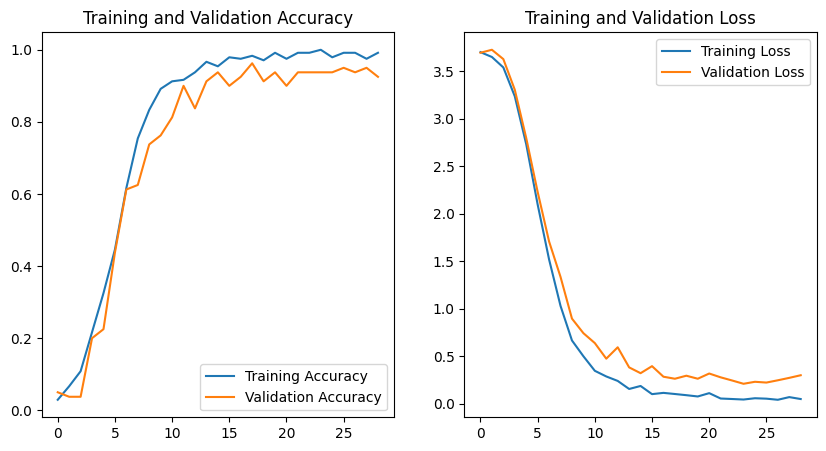

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Fast gradient sign method

In [20]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.05)
X_test_fgsm = attack_fgsm.generate(x=X_test)

In [12]:
def l0_norm(real, adversarial):
    return np.sum(real != adversarial)

def l2_norm(real, adversarial):
    return np.linalg.norm(real - adversarial)

def linf_norm(real, adversarial):
    return np.max(np.abs(real - adversarial))

def ssim_index(real, adversarial):
    real = real.astype(np.float64).squeeze(-1)
    adversarial = adversarial.astype(np.float64).squeeze(-1)
    return ssim(real, adversarial, data_range=1)

def psnr_index(real, adversarial):
    return psnr(real, adversarial, data_range=1)
# and combine this with different epsilons in fast gradient attack

In [13]:
l0_dists = []
l2_dists = []
linf_dists = []
ssim_scores = []
psnr_scores = []

for real_img, adv_img in zip(X_test, X_test_fgsm):
    l0_dists.append(l0_norm(real_img, adv_img))
    l2_dists.append(l2_norm(real_img, adv_img))
    linf_dists.append(linf_norm(real_img, adv_img))
    ssim_scores.append(ssim_index(real_img, adv_img))
    psnr_scores.append(psnr_index(real_img, adv_img))

avg_l0 = np.mean(l0_dists)
avg_l2 = np.mean(l2_dists)
avg_linf = np.mean(linf_dists)
avg_ssim = np.mean(ssim_scores)
avg_psnr = np.mean(psnr_scores)

print(f"Average L0 Distortion: {avg_l0}")
print(f"Average L2 Distortion: {avg_l2}")
print(f"Average L∞ Distortion: {avg_linf}")
print(f"Average SSIM: {avg_ssim}")
print(f"Average PSNR: {avg_psnr}")

Average L0 Distortion: 4096.0
Average L2 Distortion: 6.194451695818115
Average L∞ Distortion: 0.10000001528683829
Average SSIM: 0.5540147500808598
Average PSNR: 20.283547034053804


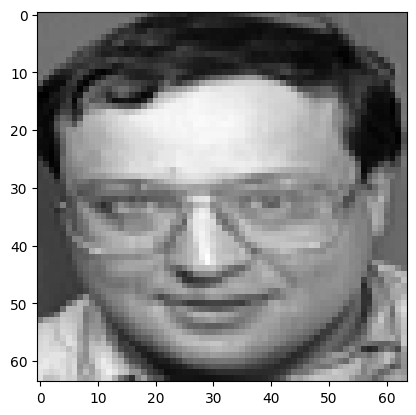

In [14]:
plt.imshow(X_test[0].squeeze(), cmap='gray')

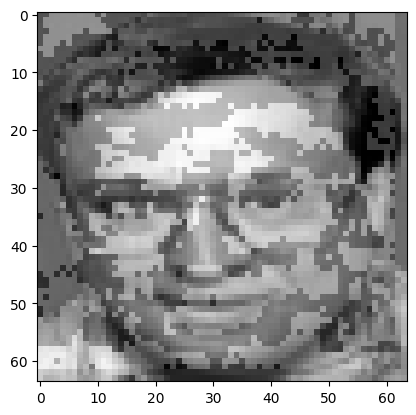

In [15]:
plt.imshow(X_test_fgsm[0].squeeze(), cmap='gray')

In [16]:
score_clean = model.evaluate(x=X_test, y=y_test)
score_fgsm = model.evaluate(x=X_test_fgsm, y=y_test)

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs FGSM test set loss: {score_fgsm[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs FGSM test set accuracy: {score_fgsm[1]:.2f}")

3/3 [==============================] - 0s 6ms/step - loss: 12.7188 - accuracy: 0.0000e+00
Clean test set loss: 0.53 vs FGSM test set loss: 12.72
Clean test set accuracy: 0.91 vs FGSM test set accuracy: 0.00


1/1 [==============================] - 0s 34ms/step


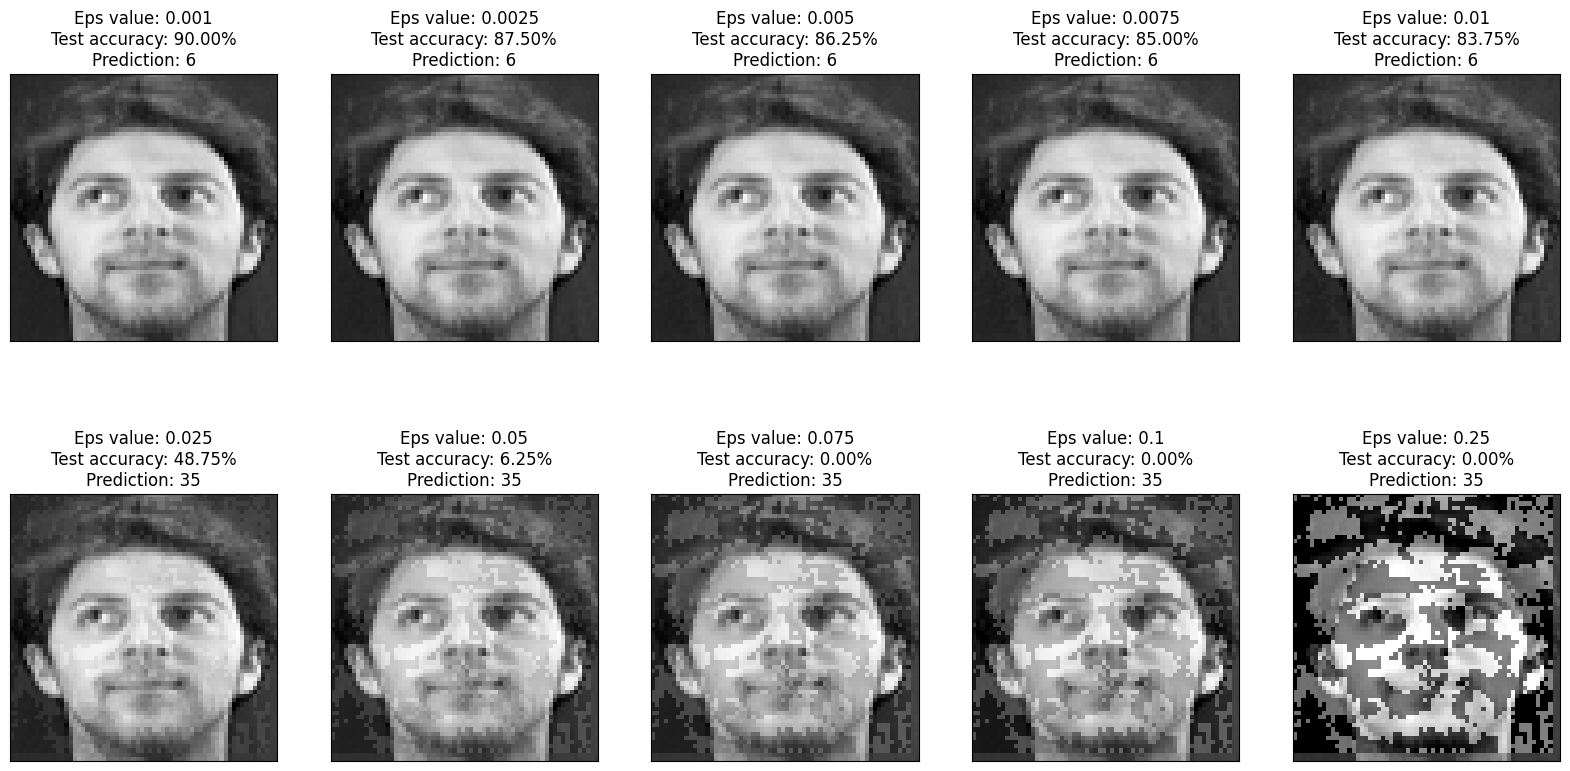

In [17]:
# plot setting
nrows, ncols = 2, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

eps_to_try = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25]
counter = 0

for i in range(nrows):
    for j in range(ncols):

        attack_fgsm = FastGradientMethod(estimator=classifier, eps=eps_to_try[counter])
        X_test_fgsm = attack_fgsm.generate(x=X_test)

        axes[i, j].imshow(X=X_test_fgsm[5].squeeze(), cmap='gray')
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        test_score = classifier._model.evaluate(x=X_test_fgsm, y=y_test)[1]
        prediction = np.argmax(model.predict(x=np.expand_dims(a=X_test_fgsm[5], axis=0)))

        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )

        counter += 1

plt.show()

# Deepfool

In [ ]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_df = DeepFool(classifier=classifier)
X_test_df = attack_df.generate(x=X_test)

DeepFool:   0%|          | 0/80 [00:00<?, ?it/s]

In [ ]:
l0_dists = []
l2_dists = []
linf_dists = []
ssim_scores = []
psnr_scores = []

for real_img, adv_img in zip(X_test, X_test_df):
    l0_dists.append(l0_norm(real_img, adv_img))
    l2_dists.append(l2_norm(real_img, adv_img))
    linf_dists.append(linf_norm(real_img, adv_img))
    ssim_scores.append(ssim_index(real_img, adv_img))
    psnr_scores.append(psnr_index(real_img, adv_img))

avg_l0 = np.mean(l0_dists)
avg_l2 = np.mean(l2_dists)
avg_linf = np.mean(linf_dists)
avg_ssim = np.mean(ssim_scores)
avg_psnr = np.mean(psnr_scores)

print(f"Average L0 Distortion: {avg_l0}")
print(f"Average L2 Distortion: {avg_l2}")
print(f"Average L∞ Distortion: {avg_linf}")
print(f"Average SSIM: {avg_ssim}")
print(f"Average PSNR: {avg_psnr}")

Average L0 Distortion: 4096.0
Average L2 Distortion: 11.882126244191571
Average L∞ Distortion: 0.5398259504490038
Average SSIM: 0.5285061649143457
Average PSNR: 23.419404264578368


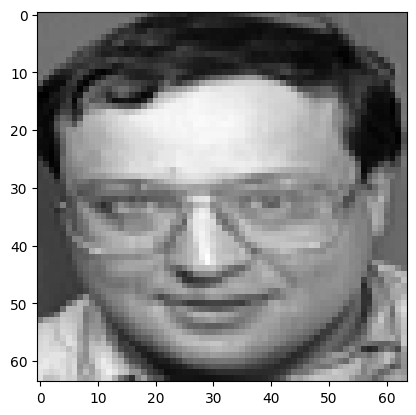

In [ ]:
plt.imshow(X_test[0].squeeze(), cmap='gray')

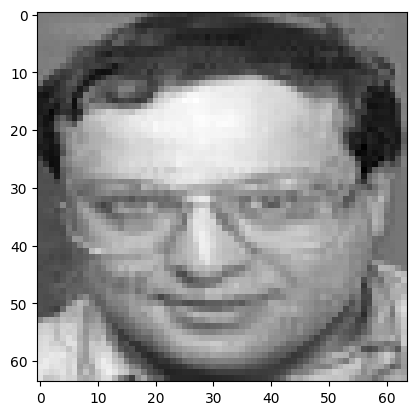

In [ ]:
plt.imshow(X_test_df[0].squeeze(), cmap='gray')

In [ ]:
score_clean = model.evaluate(x=X_test, y=y_test)
score_df = model.evaluate(x=X_test_df, y=y_test)

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs DF test set loss: {score_df[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs DF test set accuracy: {score_df[1]:.2f}")

3/3 [==============================] - 0s 5ms/step - loss: 24.0961 - accuracy: 0.0250
Clean test set loss: 0.46 vs DF test set loss: 24.10
Clean test set accuracy: 0.91 vs DF test set accuracy: 0.03


# Universal perturbation

In [36]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_up = UniversalPerturbation(classifier=classifier, attacker='fgsm', eps=0.1)
X_test_up = attack_up.generate(x=X_test)

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

In [39]:
l0_dists = []
l2_dists = []
linf_dists = []
ssim_scores = []
psnr_scores = []

for real_img, adv_img in zip(X_test, X_test_up):
    l0_dists.append(l0_norm(real_img, adv_img))
    l2_dists.append(l2_norm(real_img, adv_img))
    linf_dists.append(linf_norm(real_img, adv_img))
    ssim_scores.append(ssim_index(real_img, adv_img))
    psnr_scores.append(psnr_index(real_img, adv_img))

avg_l0 = np.mean(l0_dists)
avg_l2 = np.mean(l2_dists)
avg_linf = np.mean(linf_dists)
avg_ssim = np.mean(ssim_scores)
avg_psnr = np.mean(psnr_scores)

print(f"Average L0 Distortion: {avg_l0}")
print(f"Average L2 Distortion: {avg_l2}")
print(f"Average L∞ Distortion: {avg_linf}")
print(f"Average SSIM: {avg_ssim}")
print(f"Average PSNR: {avg_psnr}")

Average L0 Distortion: 4096.0
Average L2 Distortion: 6.182548201362266
Average L∞ Distortion: 0.10000000000000006
Average SSIM: 0.5643953864809428
Average PSNR: 20.300264135010522


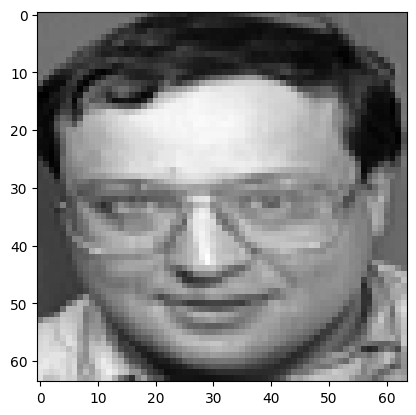

In [40]:
plt.imshow(X_test[0].squeeze(), cmap='gray')

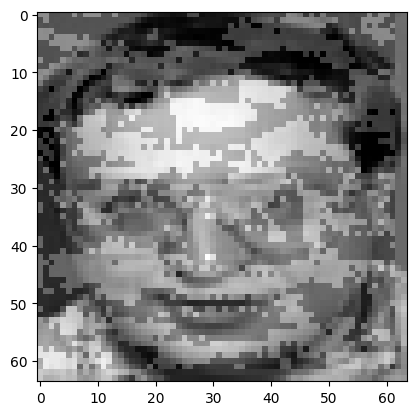

In [41]:
plt.imshow(X_test_up[0].squeeze(), cmap='gray')

In [42]:
score_clean = model.evaluate(x=X_test, y=y_test)
score_up = model.evaluate(x=X_test_up, y=y_test)

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs UP test set loss: {score_up[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs UP test set accuracy: {score_up[1]:.2f}")

3/3 [==============================] - 0s 101ms/step - loss: 3.0173 - accuracy: 0.4000
Clean test set loss: 0.46 vs UP test set loss: 3.02
Clean test set accuracy: 0.91 vs UP test set accuracy: 0.40


# Defensive distilation

In [11]:
def build_model_dist_teacher(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(40)
    ])
    return model

def softened_softmax(logits, temperature=1):
    soft_max_output = Softmax()(logits / temperature)
    return soft_max_output

def build_model_dist_student(input_shape, use_softmax=True, temperature=1.0):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(40)  # No activation here
    ])

    if use_softmax:
        # Apply softened softmax during training
        model.add(Lambda(lambda x: softened_softmax(x, temperature)))
    else:
        # Use standard softmax during evaluation
        model.add(Softmax())

    return model


In [12]:
loss_dist = SparseCategoricalCrossentropy(from_logits=True)
teacher_model = build_model_dist_teacher((64, 64, 1))
teacher_model.compile(optimizer='adam', loss=loss_dist, metrics=['accuracy'])
teacher_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Get logits from the teacher model
logits = teacher_model.predict(X_train)
print("Logits Shape:", logits.shape)

Epoch 1/50
15/15 [==============================] - 3s 19ms/step - loss: 3.7231 - accuracy: 0.0250 - val_loss: 3.6845 - val_accuracy: 0.0250
Epoch 2/50
15/15 [==============================] - 0s 8ms/step - loss: 3.6449 - accuracy: 0.0875 - val_loss: 3.6820 - val_accuracy: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 0s 8ms/step - loss: 3.5320 - accuracy: 0.1125 - val_loss: 3.5844 - val_accuracy: 0.0250
Epoch 4/50
15/15 [==============================] - 0s 7ms/step - loss: 3.1506 - accuracy: 0.1792 - val_loss: 3.3214 - val_accuracy: 0.1500
Epoch 5/50
15/15 [==============================] - 0s 7ms/step - loss: 2.6172 - accuracy: 0.4000 - val_loss: 2.8125 - val_accuracy: 0.2500
Epoch 6/50
15/15 [==============================] - 0s 7ms/step - loss: 1.8701 - accuracy: 0.5167 - val_loss: 2.0925 - val_accuracy: 0.4625
Epoch 7/50
15/15 [==============================] - 0s 7ms/step - loss: 1.1460 - accuracy: 0.7167 - val_loss: 1.4260 - val_accuracy: 0.7375
Epoch 8/50
15/1

In [13]:
student_labels = softened_softmax(logits, temperature=10)

In [14]:
# Compile the student model for training with categorical crossentropy
student_model = build_model_dist_student(input_shape=(64, 64, 1), use_softmax=True, temperature=10)
student_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
y_val = to_categorical(y_val, num_classes=40)
student_model.fit(
    X_train, student_labels,   # Using the correctly shaped soft labels for training
    validation_data=(X_val, y_val),  # Using the correctly shaped labels for validation
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping]
)

Epoch 1/50
15/15 [==============================] - 2s 59ms/step - loss: 3.6862 - accuracy: 0.0417 - val_loss: 3.6911 - val_accuracy: 0.0375
Epoch 2/50
15/15 [==============================] - 0s 7ms/step - loss: 3.6821 - accuracy: 0.0083 - val_loss: 3.6856 - val_accuracy: 0.0125
Epoch 3/50
15/15 [==============================] - 0s 8ms/step - loss: 3.6768 - accuracy: 0.0500 - val_loss: 3.6572 - val_accuracy: 0.0375
Epoch 4/50
15/15 [==============================] - 0s 9ms/step - loss: 3.6672 - accuracy: 0.0833 - val_loss: 3.5776 - val_accuracy: 0.0750
Epoch 5/50
15/15 [==============================] - 0s 8ms/step - loss: 3.6530 - accuracy: 0.1500 - val_loss: 3.4716 - val_accuracy: 0.1125
Epoch 6/50
15/15 [==============================] - 0s 7ms/step - loss: 3.6414 - accuracy: 0.2500 - val_loss: 3.3580 - val_accuracy: 0.2125
Epoch 7/50
15/15 [==============================] - 0s 8ms/step - loss: 3.6293 - accuracy: 0.3292 - val_loss: 3.2747 - val_accuracy: 0.3000
Epoch 8/50
15/15 [=

In [15]:
student_model_eval = build_model_dist_student(input_shape=(64, 64, 1), use_softmax=False)
student_model_eval.set_weights(student_model.get_weights())  # Transfer weights from the trained model
student_model_eval.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
y_test = to_categorical(y_test, num_classes=40)

In [21]:
score_clean = student_model_eval.evaluate(x=X_test, y=y_test)
score_fgsm = student_model_eval.evaluate(x=X_test_fgsm, y=y_test)

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs adv test set loss: {score_fgsm[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs adv test set accuracy: {score_fgsm[1]:.2f}")

3/3 [==============================] - 0s 5ms/step - loss: 1.3541 - accuracy: 0.6375
Clean test set loss: 0.52 vs adv test set loss: 1.35
Clean test set accuracy: 0.91 vs adv test set accuracy: 0.64
